In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from helper import *
from collections import Counter
from matplotlib.gridspec import GridSpec
import math as m

sns.set_style("darkgrid")

### Podcast Analysis
In this analysis we are looking at the podcast review dataset with 2 million reviews on 100k podcasts<br> and updated monthly.

More info on the dataset on [Kaggle page](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28).

Duckdb is used to efficiently run SQL queries on pandas DataFrame.

#### Load and connect with sqlite database using duckdb

In [2]:
# only run these once
duckdb.sql("INSTALL sqlite")
duckdb.sql("LOAD sqlite")
duckdb.sql("ATTACH './podcast.sqlite' (TYPE sqlite);")

Let's see what tables are in the podcast database:

In [3]:
qry("SHOW ALL TABLES")

,database,schema,name,column_names,column_types,temporary
0,podcast,main,categories,"[podcast_id, category]","[VARCHAR, VARCHAR]",False
1,podcast,main,podcasts,"[podcast_id, itunes_id, slug, itunes_url, title]","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR]",False
2,podcast,main,reviews,"[podcast_id, title, content, rating, author_id...","[VARCHAR, VARCHAR, VARCHAR, BIGINT, VARCHAR, V...",False
3,podcast,main,runs,"[run_at, max_rowid, reviews_added]","[VARCHAR, BIGINT, BIGINT]",False


In [4]:
categories = qry("SELECT * FROM podcast.categories")
categories.head()

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design


In [5]:
podcasts = qry("SELECT * FROM podcast.podcasts")
podcasts.head()

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-...,Word on the Street w/ Dreak Swift


In [6]:
reviews = qry("SELECT * FROM podcast.reviews")
reviews.head()

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [18]:
bprint(
    "runs table document the time when the reviews were added, this table would not be used in the analysis."
)
runs = qry("SELECT * FROM podcast.runs")
runs.tail(5)


runs table document the time when the reviews were added, this table would not be used in the analysis.


,run_at,max_rowid,reviews_added
11,2022-09-07 15:28:17,5319820,15736
12,2022-10-01 21:56:38,5364248,16649
13,2022-11-03 21:12:30,5427586,22495
14,2022-12-10 01:17:07,5488314,21333
15,2023-02-18 02:11:53,5599789,42196


#### Data cleaning

- Check for null and duplication.

- The only numeric column is rating column in the reviews table.<br> Check whether there's null or anamolies in this column.
  
- Cast the `created_at` column in reviews table to the correct datetime format.

In [8]:
# check null in all tables
categories_null_count = categories.isnull().sum().sum()
podcasts_null_count = podcasts.isnull().sum().sum()
reviews_null_count = reviews.isnull().sum().sum()

# check duplication for podcast_id in podcasts column
podcasts_id_dup = podcasts.podcast_id.duplicated().sum()

# all possible content in reviews.rating column
all_ratings = Counter(reviews.rating)

# cast created_at date column in reviews table
# discard columns with non-ASCII characters in created_at column

non_ascii = list(
    qry(
        """
SELECT
  podcast_id,
  title
FROM
  reviews
WHERE
  LEFT(created_at, 1) != '2'    
"""
    ).title
)
reviews = reviews[~reviews.title.isin(non_ascii)]

# only run if the casted column has not existed yet
if "created_at_dt" not in reviews.columns:
    reviews = qry(
        """
    SELECT
      *,
      created_at:: datetime AS created_at_dt
    FROM
      reviews    
    """
    )

bprint("Tables null count:")
print(
    f"categories_null: {categories_null_count},\npodcasts_null: {podcasts_null_count},\nreviews_null: {reviews_null_count},\n "
)

bprint("Podcast_id duplication count:")
print(f"podcast_dup: {podcasts_id_dup}")

bprint("All possible contents in rating column")
print(sorted(list(all_ratings.keys())))

bprint("Reviews table date column type:")
print(reviews.created_at_dt.dtype)


Tables null count:
categories_null: 0,
podcasts_null: 0,
reviews_null: 0,
 

Podcast_id duplication count:
podcast_dup: 0

All possible contents in rating column
[1, 2, 3, 4, 5]

Reviews table date column type:
datetime64[us]


📝 Cleaning results:
- No column in the tables contains null.

- There's no duplication in podcast_id.

- Rating column in rating table exclusively consists of rating numbers ranging from 1 to 5.

Thus we don't need to take any action here.

----------------------------------------------------------------------------------------------------------------------------

#### EDA

Let's investigate the data distribution in `category` and `reviews` table.

📊 Category Table


Number of unique podcast category: 
110

Total number of distinct podcasts with category:
110024

Total number of category-podcast pairs:
212372

Number of podcasts in category:


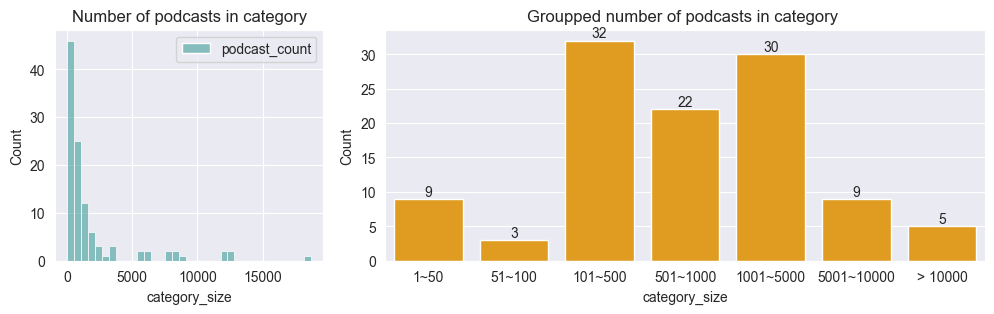


Distribution Stats:
       podcast_count
count     110.000000
mean     1930.654545
std      3258.322196
min        14.000000
25%       288.250000
50%       727.000000
75%      1568.500000
max     18710.000000

Top 10 categories with most podcasts:
                category  podcast_count
0        society-culture          18710
1              education          12628
2                 comedy          12464
3  religion-spirituality          12190
4               business          12058
5                   arts           8953
6                 sports           8388
7         health-fitness           8123
8           christianity           7954
9                tv-film           7714

Top 10/ total ratio:
Top 10 categories contains 51.41% of all the podcasts

Bottom 10 categories with least podcasts:
              category  podcast_count
0    sports-volleyball             14
1  science-mathematics             16
2    science-chemistry             17
3      sports-swimming             18
4 

In [9]:
total_pod = qry(
    """
SELECT
  COUNT(DISTINCT podcast_id) pod_count
FROM
  podcasts    
"""
)
distinct_podcast = qry(
    """
SELECT
  COUNT(podcast_id) total_podcast_category_pairs,
  COUNT(DISTINCT podcast_id) distinct_podcasts
FROM
  categories    
"""
)
unique_categories = qry(
    """
SELECT
  COUNT(DISTINCT category) distinct_category_count
FROM
  categories    
"""
)
top_ten_categories = qry(
    """
SELECT
  category,
  COUNT(*) podcast_count
FROM
  categories
GROUP BY
  category
ORDER BY
  COUNT(*) DESC
LIMIT
  10    
"""
)
bottom_ten_categories = qry(
    """
SELECT
  category,
  COUNT(*) podcast_count
FROM
  categories
GROUP BY
  category
ORDER BY
  COUNT(*)
LIMIT
  10    
"""
)
all_categories_count = qry(
    """
SELECT
  category,
  COUNT(*) podcast_count
FROM
  categories
GROUP BY
  category
ORDER BY
  COUNT(*) DESC    
"""
)

pod_category_count_groupping_qry = qry(
    """
SELECT
  category,
  COUNT(*) total,
  CASE
    WHEN COUNT(*) < 50 THEN 1
    WHEN COUNT(*) < 100 THEN 2
    WHEN COUNT(*) < 500 THEN 3
    WHEN COUNT(*) < 1000 THEN 4
    WHEN COUNT(*) < 5000 THEN 5
    WHEN COUNT(*) < 10000 THEN 6
    WHEN COUNT(*) > 10000 THEN 7
  END AS pod_count_group
FROM
  categories
GROUP BY
  category
ORDER BY
  COUNT(*) DESC    
"""
)


pod_per_cat_qry = qry(
    """
SELECT
  pod_count_group,
  SUM(total) total_pod,
  COUNT(pod_count_group) cat_in_group,
  SUM(total) / 212372.0 AS proportion
FROM
  pod_category_count_groupping_qry
GROUP BY
  pod_count_group    
"""
)


bprint("Number of unique podcast category: ")
print(unique_categories.distinct_category_count[0])
bprint("Total number of distinct podcasts with category:")
print(distinct_podcast.distinct_podcasts[0])
bprint("Total number of category-podcast pairs:")
print(distinct_podcast.total_podcast_category_pairs[0])

bprint("Number of podcasts in category:")
fs(12, 3)
gs = GridSpec(1, 6, wspace=0.6)
plt.subplot(gs[0:1, 2:6])
ax = sns.barplot(
    x=pod_per_cat_qry.pod_count_group, y=pod_per_cat_qry.cat_in_group, color="orange"
)
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["1~50", "51~100", "101~500", "501~1000",
        "1001~5000", "5001~10000", "> 10000"],
)
plt.ylabel("Count")
plt.xlabel("category_size")
mark_bar(ax)
plt.title("Groupped number of podcasts in category ")

plt.subplot(gs[0:1, 0:2])
sns.histplot(all_categories_count, palette="viridis")
plt.title("Number of podcasts in category")
plt.xlabel("category_size")

s()
bprint("Distribution Stats:")
print(all_categories_count.describe())

bprint("Top 10 categories with most podcasts:")
print(top_ten_categories)
bprint("Top 10/ total ratio:")
print(
    f"Top 10 categories contains {round_percent(all_categories_count.head(10).podcast_count.sum()/all_categories_count.podcast_count.sum(), has_percent=True)} of all the podcasts"
)

bprint("Bottom 10 categories with least podcasts:")
print(bottom_ten_categories)

📝 Category Table

- There are 110 categories
- There are in total `~110,000 distinct podcasts`.
- All podcasts are assigned to its category.
- `Some podcasts belongs to more than one category`,<br> 
there are ~212,000 podcast-category pairs.
- The podcasts count distribution in categories is `highly right skewed`.
<br> The mean is 1930 while the median is only 727.
- Non parametric method should be applied for further analysis.
- There are 14 categories (more than 10% of total categories) with more than 5000 podcasts,
<br> while 12 categories only have less than 100 podcasts.
- Top 10 categories with the most podcasts covers a wide spectrum of topics with no clear overlap.
- `Top 10 categories contains more than 50% of all the podcasts`.

- `Bottom 10 categories` with the least podcasts are mostly about `science and sports`.


📊 Let's combine category and review table to compare reviews between the categories.

- Which are some higly rated and lowly rated categories ?
- What might be the reason ?


Categories with highest rating
                       category  total_review  avg_rev_per_pod
100  education-self-improvement        103961        17.918132
101    health-fitness-nutrition         22148        39.061728
102           science-chemistry           162         9.529412
103            business-careers         53921        22.053579
104              sports-running          6157        40.241830
105             sports-swimming           130         7.222222
106         business-non-profit          2570         5.079051
107   business-entrepreneurship         80242        22.283255
108          business-marketing         28869        20.591298
109                sports-rugby           167         4.771429

Categories with lowest rating
                        category  total_review  avg_rev_per_pod
0                news-daily-news         15030        46.822430
1                     true-crime        162550       128.599684
2                  news-politics         47888      

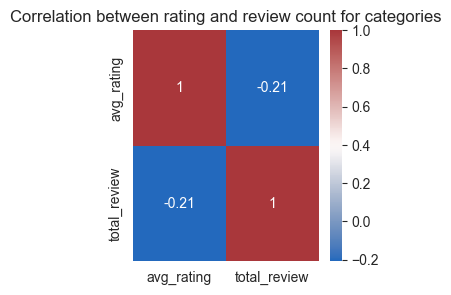

In [10]:
category_rating = qry(
    """
SELECT
  cat.category,
  AVG(rev.rating) AS avg_rating,
  COUNT(rev.rating) AS total_review,
  COUNT(DISTINCT cat.podcast_id) AS category_size
FROM
  reviews rev
  JOIN categories cat ON rev.podcast_id = cat.podcast_id
GROUP BY
  cat.category
ORDER BY
  avg_rating    
"""
)

category_rating["avg_rev_per_pod"] = (
    category_rating.total_review / category_rating.category_size
)

cat_corr = category_rating[["avg_rating", "total_review"]].corr(
    method="spearman")

bprint("Categories with highest rating")
print(
    category_rating[["category", "total_review", "avg_rev_per_pod"]].tail(10))

bprint("Categories with lowest rating")
print(
    category_rating[["category", "total_review", "avg_rev_per_pod"]].head(10))

fs(3, 3)
sns.heatmap(cat_corr, cmap="vlag", annot=True)
plt.title("Correlation between rating and review count for categories")
s()

📝 Category and its rating 

- Categories with lower ratings are mostly news, crime, politics,<br> 
government related. These are topics that are more opinionated by nature.<br> 
People might get more emotional listening to these podcasts, thus increasing<br> 
the chance of leaving reviews, and more negative reviews.

- In the correlation table between categories ratings and review count, rating<br> has slight to moderate negative 
  correlation (-0.21) with review numbers.


📊 Review Table


Total review count:
2067527

Distinct podcasts reviewed:
111544

Most podcasts have more than one reviews: 


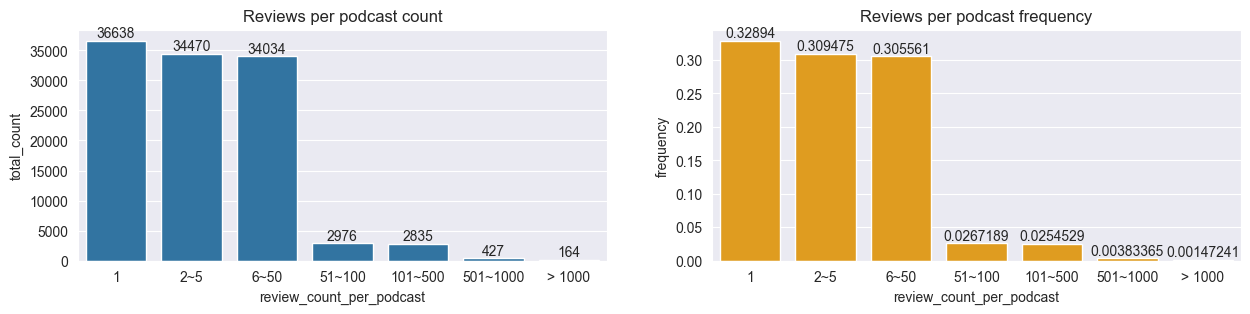


Distinct review authors: 
1475283

Review rating: 


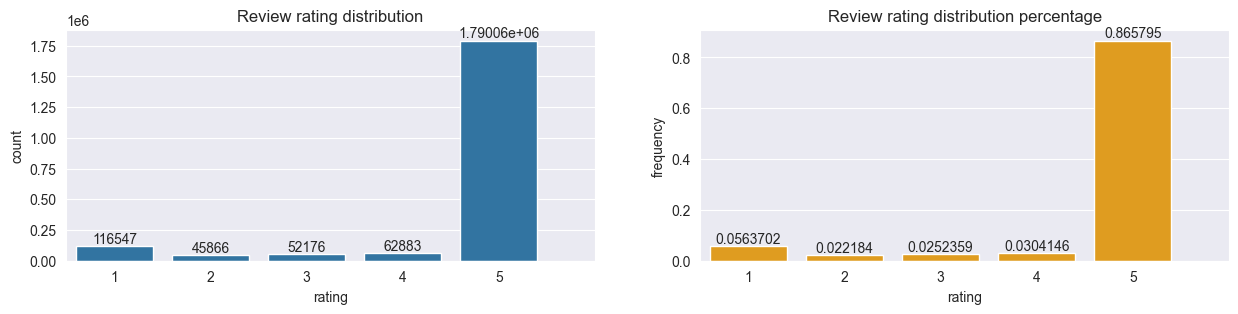

In [11]:
total_review_count = qry("SELECT COUNT(*) total_count FROM reviews")
distinct_pod_reviewed = qry(
    "SELECT COUNT(DISTINCT podcast_id) total FROM reviews")

rev_pod_id = set(reviews.podcast_id)
pod_pod_id = set(podcasts.podcast_id)
pod_diff = len(rev_pod_id.difference(pod_pod_id))
rev_diff = len(
    reviews[reviews.podcast_id.isin(list(rev_pod_id.difference(pod_pod_id)))]
)

rev_author_count = qry("SELECT COUNT(DISTINCT author_id) total FROM reviews")
rev_total = qry("SELECT COUNT(*) AS tt_count FROM reviews").tt_count[0]

rating_count = qry(
    f"""
SELECT
  rating,
  COUNT(rating) total,
  COUNT(rating) /{rev_total}frequency
FROM
  reviews
GROUP BY
  rating    
"""
)

pod_reviews_agg = qry(
    """
SELECT
  podcast_id,
  COUNT(podcast_id) rev_count
FROM
  reviews
GROUP BY
  podcast_id    
"""
)

pod_reviews_count_groupping_qry = qry(
    """
SELECT
  podcast_id,
  CASE
    WHEN COUNT(*) = 1 THEN 1
    WHEN COUNT(*) < 5 THEN 2
    WHEN COUNT(*) < 50 THEN 3
    WHEN COUNT(*) < 100 THEN 4
    WHEN COUNT(*) < 500 THEN 5
    WHEN COUNT(*) < 1000 THEN 6
    WHEN COUNT(*) > 1000 THEN 7
  END AS review_count_per_podcast
FROM
  reviews
GROUP BY
  podcast_id
ORDER BY
  review_count_per_podcast DESC    
"""
)


reviews_per_pod_qry = qry(
    """
SELECT
  review_count_per_podcast,
  COUNT(review_count_per_podcast) AS total_count,
  COUNT(review_count_per_podcast) / 111382.0 AS frequency
FROM
  pod_reviews_count_groupping_qry
GROUP BY
  review_count_per_podcast
ORDER BY
  review_count_per_podcast    
"""
)

bprint("Total review count:")
print(total_review_count.total_count[0])
bprint("Distinct podcasts reviewed:")
print(distinct_pod_reviewed.total[0])
bprint("Most podcasts have more than one reviews: ")
fs(15, 3)
# rev_pod count
plt.subplot(1, 2, 1)
ax = sns.barplot(
    x=reviews_per_pod_qry.review_count_per_podcast, y=reviews_per_pod_qry.total_count
)
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["1", "2~5", "6~50", "51~100", "101~500", "501~1000", "> 1000"],
)
plt.title("Reviews per podcast count")
mark_bar(ax)

# rev_pod frequency
plt.subplot(1, 2, 2)
ax = sns.barplot(
    x=reviews_per_pod_qry.review_count_per_podcast,
    y=reviews_per_pod_qry.frequency,
    color="orange",
)
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["1", "2~5", "6~50", "51~100", "101~500", "501~1000", "> 1000"],
)
plt.title("Reviews per podcast frequency")

mark_bar(ax)

s()
bprint("Distinct review authors: ")
print(rev_author_count.total[0])

# distribution plot
bprint("Review rating: ")
fs(15, 3)
# rating count
plt.subplot(1, 2, 1)
ax = sns.barplot(data=rating_count, x="rating", y="total")
mark_bar(ax)
plt.xticks([0, 1, 2, 3, 4, 5])
plt.xlabel("rating")
plt.ylabel("count")
plt.title("Review rating distribution")

# rating frequency
plt.subplot(1, 2, 2)
ax = sns.barplot(data=rating_count, x="rating", y="frequency", color="orange")
mark_bar(ax)
plt.xticks([0, 1, 2, 3, 4, 5])
plt.xlabel("rating")
plt.ylabel("frequency")
plt.title("Review rating distribution percentage")
s()

📝 Review table
- There's `~2 millions reviews`, and `~1 million distinct podcasts` being reviewed.
  
- `More than 90% of the podcasts have less than 50 reviews`.
- There are `~1.5 millions distinct review authors`.
- Rating data is highly imbalanced, `more than 86% of the review ratings are 5`.

📊 
Is there a difference in review count `across different time units` ? 

The data here spans from 2006 ~ 2023 Feb.


Review time series distributions:


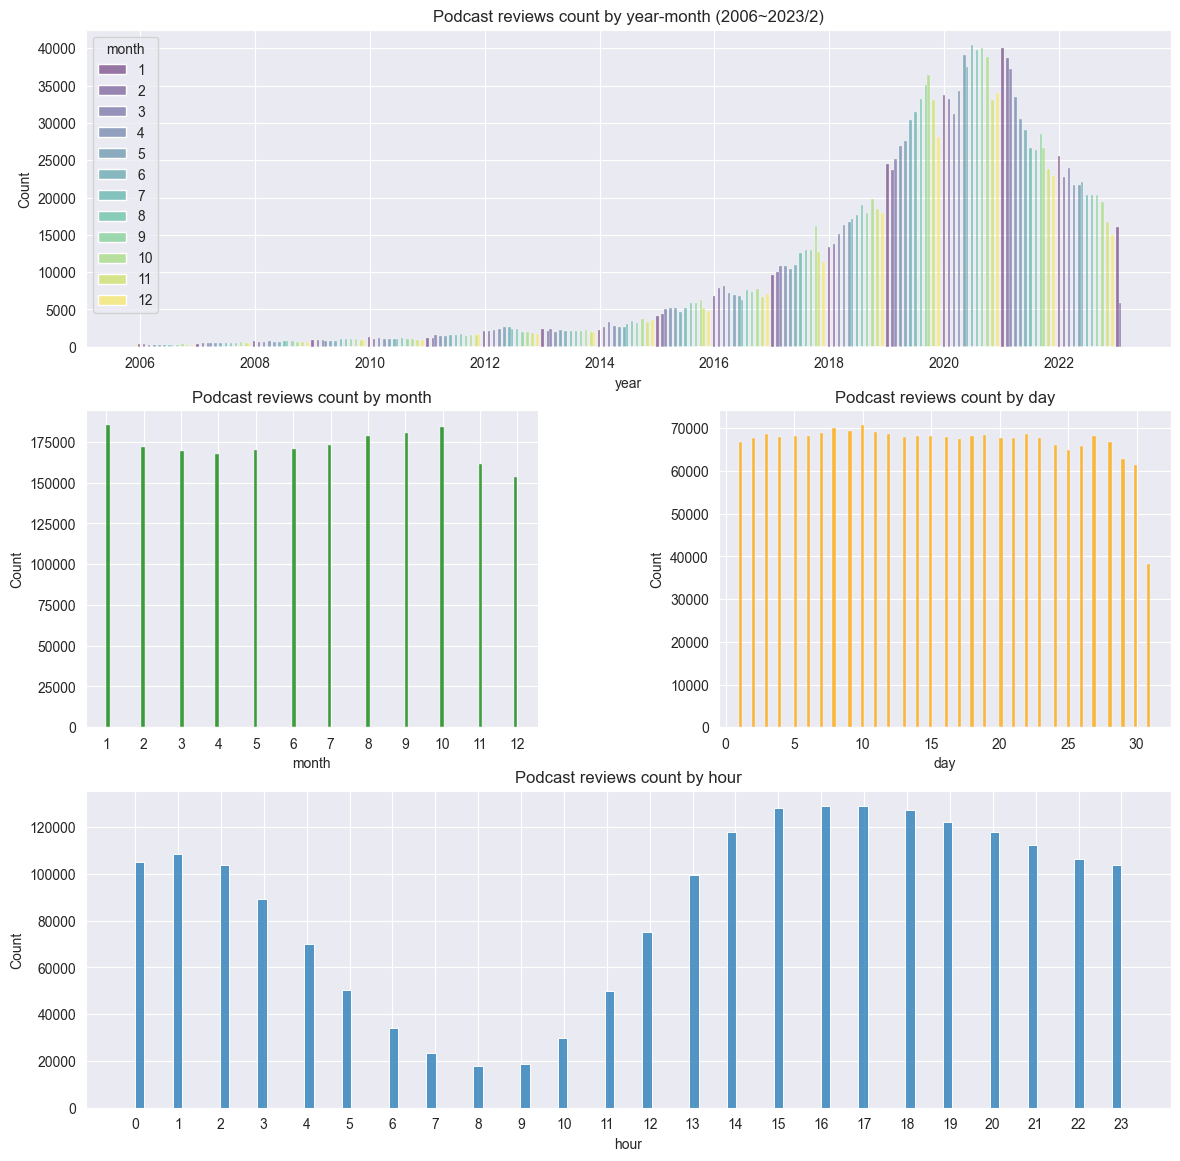

In [12]:
year_reviews = qry(
    """
SELECT
  DATE_TRUNC('month', created_at_dt) AS year,
  DATE_PART('month', created_at_dt) AS month
FROM
  reviews    
"""
)
month_reviews = qry(
    "SELECT DATE_PART('month', created_at_dt) AS month FROM reviews")

day_reviews = qry("SELECT DATE_PART('day', created_at_dt) AS day FROM reviews")

hour_reviews = qry(
    "SELECT DATE_PART('hour', created_at_dt) AS hour FROM reviews")

bprint("Review time series distributions:")
fs(14, 14)
gs = GridSpec(3, 2, wspace=0.4)
# year
plt.subplot(gs[0:1, :])
sns.histplot(data=year_reviews, x="year", hue="month", palette="viridis")
plt.title("Podcast reviews count by year-month (2006~2023/2)")
# month
plt.subplot(gs[1:2, 0:1])
sns.histplot(data=month_reviews, x="month", color="green")
plt.title("Podcast reviews count by month")
plt.xticks(range(1, 13))
# day
plt.subplot(gs[1:2, 1:2])
sns.histplot(data=day_reviews, x="day", color="orange")
plt.title("Podcast reviews count by day")

# hour
plt.subplot(gs[2:3, :])
sns.histplot(data=hour_reviews, x="hour")
plt.xticks(range(0, 24))

plt.title("Podcast reviews count by hour")
s()

📝 Review time series analysis

- `The number of reviews peak at year 2020 and 2021, and starts to decline in 2022`.<br> 
This growth pattern comes from the develop of the pandemic. [study_source](https://www.nielsen.com/insights/2022/u-s-podcast-listenership-continues-to-grow-and-audiences-are-resuming-many-pre-pandemic-spending-behaviors/#:~:text=During%20a%20pandemic%20that%20drove,engagement%20among%20listeners%20is%20growing.])

- November and December are two months with the least reviews. Possibly due to holidays <br>
in these two months (Halloween, Thanksgiving, Saint Nicholas Day, Christmas...)
- The days with the least reviews are 29, 30, 31st, as there are 5 months without day-31, <br>
and that Feburary only has 28 or 29 days, this is expected. Apart from that, the reviews on the days are similar.
- Looking at the hours, `most reviews happen during the afternoon (15:00~18:00)`.<br>
`Least reviews are coming from the start of working hours (7:00~9:00)`.<br> 
The biggest difference is 6 times !


📊 The number of reviews fluctuates a lot across different hours.<br> 
Let's look at whether rating also has different distribution across hours. 

However, we need to think twice about the stats.

As our `rating data is highly skewed`, it's more suitable to use robost stats like median <br>
instead of mean when making comparison between hours. 

However, as 86% of the rating is 5, the median of either the whole population or individual<br> 
hours are all 5. We cannot extract meaningful insights using median. 

Thus here we define a new metric, `High-Rating Proportion (HRP)`, with which we calculate <br>
the proportion of rating 4 & 5 in the total rating (rating 4 & 5 count/ total rating count). 

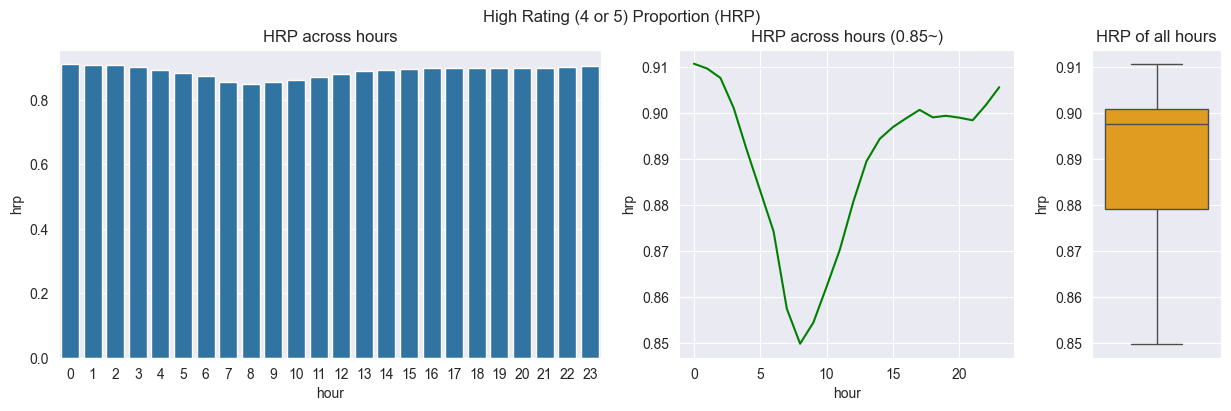


Distribution statistics:
count    24.000000
mean      0.889091
std       0.018237
min       0.849947
25%       0.879109
50%       0.897741
75%       0.900823
max       0.910749
Name: hrp, dtype: float64

Hours and high rating proportion of the bottom 25% percentile
hour   high_rating_Proportion
6     0.874344
7     0.857541
8     0.849947
9     0.854561
10    0.862361
11    0.870438
Name: hrp, dtype: float64

=> the hours with the lowest high-rating proportion is from 6~ 11


In [13]:
hour_rating_reviews_total_count = qry(
    """
SELECT
  DATE_PART('hour', created_at_dt) AS hour,
  COUNT(rating) AS total_count
FROM
  reviews
GROUP BY
  DATE_PART('hour', created_at_dt)    
"""
)

hour_rating_reviews_high_rating_count = qry(
    """
SELECT
  DATE_PART('hour', created_at_dt) AS hour,
  COUNT(rating) AS pos_count
FROM
  reviews
WHERE
  rating IN (4, 5)
GROUP BY
  DATE_PART('hour', created_at_dt)    
"""
)

hour = qry("SELECT DATE_PART('hour', created_at_dt) AS hour FROM reviews")
reviews["hour"] = hour

hrp = (
    hour_rating_reviews_high_rating_count.pos_count
    / hour_rating_reviews_total_count.total_count
)

high_rate_df = hour_rating_reviews_high_rating_count.copy()
high_rate_df["hrp"] = (
    hour_rating_reviews_high_rating_count.pos_count
    / hour_rating_reviews_total_count.total_count
)


fs(15, 4)
gs = GridSpec(1, 6, wspace=0.6)
plt.suptitle("High Rating (4 or 5) Proportion (HRP)")
plt.subplot(gs[:, 0:3])
sns.barplot(x=high_rate_df.hour, y=high_rate_df.hrp)
plt.title("HRP across hours")

plt.subplot(gs[:, 3:5])
sns.lineplot(x=high_rate_df.hour, y=high_rate_df.hrp, color="green")
plt.title("HRP across hours (0.85~)")

plt.subplot(gs[:, 5:6])

sns.boxplot(high_rate_df.hrp, color="orange")
plt.title("HRP of all hours")
s()

bprint("Distribution statistics:")
print(high_rate_df.hrp.describe())

bprint("Hours and high rating proportion of the bottom 25% percentile")
print("hour", " ", "high_rating_Proportion")
print(high_rate_df.hrp[high_rate_df.hrp < np.percentile(high_rate_df.hrp, 25)])
bprint("=> the hours with the lowest high-rating proportion is from 6~ 11")

📝 Review Rating Across Hours
 
- Here we stratified the rating data into hours to compare the <br>
High Rating Proportion (HRP) of different hour strata.
  
- First glimpse at the barplot, the HRP distribution across hours looks <br>
similar, however, as there is very high number of ratings being 5, the barplot <br>
cannot visualize the difference very well. So we use lineplot with the y-ticks <br>
starting from 0.85 to take a closer look.
  
- The HRP across hours distribution shapes like V in the lineplot, with the <br>
`minimum point at around 0.85, which is 8 am`.

- The boxplot have shown that the HRP distribution is skewed to the left <br>
(disregard the chronological order of hours).

- Notice that the timezone in this dataset is MDT (UTC-7), central america time. <br>
As there are different timezones in the US, we have to take it into consideration. <br>
For reference: the time of West coast (eg California) is UTC-8, and East coast (eg New York) is UTC-5.
  
- According to the timezone (also taking west and east coast time into consideration) <br>
its fair to say that: <br>
`It seems like the HRP of the morning hours is lower than both mean and median`.

- Let's use statistical inference and hypothesis testing to check whether this difference<br>
 is significant, and try to find the reason behind this.


----------------------------------------------------------------------------------------------------------------------------

#### Statistical Inference

📊 Hypothesis Testing

We would like to test whether the morning hours 6:00~ 11:00 <br>
have significantly lower HRP than the average HRP of the whole day. 

Let's go through the steps:

1. Decide on the stats for comparison, and check the normality <br>
of data to choose proper method for the analysis.
2. Formulate hypothesis.
3. Decide on the significance level (alpha).
4. Sample the data.

5. Perform statistical test and make inferences.


📈 Steps

**1. Stats for comparison, Check the normality, Choose analysis proper method**

=> As we are comparing the high rating `proportion` of morning hours (sample proportion) with <br>
the ones of full hours (population proportion), and the `population size is` <br>
`sufficiently large` (>2 million), we can use `binomial testing`.

**2. Formulate hypothesis.**

=> Is the morning hours HRP (6:00~11:00) significantly lower than the full hours HRP (0:00~23:00)?

H0: There's no significant difference between the morning hours HRP and the full hours HRP.

Ha: The morning hours HRP is significantly lower than the full hours HRP.

**3. Decide on the significance level (alpha).**

=> We would use `alpha= 0.05` as our significance level.

**4. Perform statistical test & make inference on the result**

In [19]:
morning_hour = [6, 7, 8, 9, 10, 11]

# population HRP
fulltime_HRP = len(
    reviews.rating[reviews.rating.isin([4, 5])]) / len(reviews.rating)

morning_reviews = reviews[reviews.hour.isin(
    morning_hour)][["podcast_id", "rating"]]

morning_reviews_sample, sample_size = data_sampling(morning_reviews, 0.01)
# sample HRP
morning_HRP = len(
    morning_reviews_sample[morning_reviews_sample.rating.isin([4, 5])]
) / len(morning_reviews_sample.rating)

reject_str = "The morning hours HRP is significantly lower than the full hours HRP."
fail_to_reject_str = "There's no significant difference between the morning hours HRP and the full hours HRP."

# run trial
binomial_test(
    morning_HRP,
    fulltime_HRP,
    0.05,
    sample_size,
    reject_str,
    fail_to_reject_str,
    alt="less",
)

Sample proportion is: 0.8627, Population proportion is: 0.8962,
sample proportion is smaller than population proportion,
test if this difference is significant:

Binomial Test Results:
BinomTestResult(k=1502, n=1741, alternative='less', statistic=0.8627225732337737, pvalue=6.412445626824015e-06)
P-value: 6.412445626824015e-06 

p_value < alpha : True
=> Reject the null hypothesis: The morning hours HRP is significantly lower than the full hours HRP.


📊
Let's also look at the confidence interval with 95% confidence.

In [15]:
# confidence interval
multiplier = 1.96  # 95% significance
population_size = len(reviews)
population_sd = m.sqrt(fulltime_HRP * (1 - fulltime_HRP) / population_size)
ci_lower = round(fulltime_HRP - multiplier * population_sd, 4)
ci_upper = round(fulltime_HRP + multiplier * population_sd, 4)

ci = f"95% Confidence Interval: {(ci_lower, ci_upper)}"
bprint("Confidence Interval for population HRP")
print(ci)
print("Morning HRP:", round(morning_HRP, 4), "does not fall in this interval.")


Confidence Interval for population HRP
95% Confidence Interval: (0.8958, 0.8966)
Morning HRP: 0.8679 does not fall in this interval.


📊 Further support for the result

After the hypothesis testing and checking with confidence interval, <br>
now we can say that:<br> 
`We are 95% confident that the morning hours HRP is significantly lower than`<br>
`its full day counterpart`.

However, why is this the case ? 

From the eda above, we observed that podcasts in the more opinionated <br>
categories such as news, politics, ...etc are getting more negative ratings.<br> 
And hobby, personal improvement related topics are getting more positve ratings. <br>
`Are the hobby and other positiveness related podcasts reviewed less in the morning hours ?`

Also, as majority of the ratings are highly positive, negative reviews are rare, <br>
`are people reviewing podcasts in the morning giving more negative ratings in general ?`

Here we can make two assumptions:
1. The podcasts that only get positive (4 or 5) ratings are reviewed less in the morning hours.
2. The authors that only give negative (1 or 2) ratings are reviewing more in the morning hours.

  
Let's use hypothesis testing again to check our assumptions:

- **💡Assumption 1**:

`Higher proportion of the podcasts that get only positive (4 or 5) reviews are reviewed`<br>
` less in the morning hours.`

H0: There's no significant difference between the review proportion of only-positively rated <br>
podcast in morning hours and the whole day.

Ha: The podcasts that get only positive reviews are reviewed significantly less in the morning hours.


In [16]:
all_pod_rating_df = qry(
    """
WITH
  all_pod_rating AS (
    SELECT
      podcast_id,
      hour,
      CASE
        WHEN rating IN (4, 5) THEN 1
        ELSE 0
      END AS high_rating_count
    FROM
      reviews
  )
SELECT
  podcast_id,
  SUM(high_rating_count) / COUNT(high_rating_count) pod_high_rating_proportion
FROM
  all_pod_rating
GROUP BY
  podcast_id    
"""
)

# find podcasts with ONLY 4 or 5 rating
podcast_with_only_high_rating = all_pod_rating_df[
    all_pod_rating_df.pod_high_rating_proportion == 1
].podcast_id

# add results into a new column
reviews["high_rating_only_pod"] = np.where(
    reviews.podcast_id.isin(podcast_with_only_high_rating), 1, 0
)

# population proportion
full_hour_high_rating_podcast_proportion = len(
    reviews[reviews.high_rating_only_pod == 1]
) / len(reviews)

morning_hour_rev = reviews[reviews.hour.isin(morning_hour)][
    ["podcast_id", "high_rating_only_pod"]
]

# sample
sample, sample_size = data_sampling(morning_hour_rev, 0.01)

morning_high_rate_pod_proportion = len(
    sample.loc[sample.high_rating_only_pod == 1]
) / len(sample)

# run trial
binomial_test(
    morning_high_rate_pod_proportion,
    full_hour_high_rating_podcast_proportion,
    0.05,
    sample_size,
    "The podcasts that get only positive reviews are reviewed significantly \n less in the morning hours",
    "There's no significant difference between the review proportion of only-positively rated podcast in morning hours and the whole day",
    alt="less",
)

Sample proportion is: 0.2269, Population proportion is: 0.2488,
sample proportion is smaller than population proportion,
test if this difference is significant:

Binomial Test Results:
BinomTestResult(k=395, n=1741, alternative='less', statistic=0.22688110281447443, pvalue=0.017732289102468768)
P-value: 0.017732289102468768 

p_value < alpha : True
=> Reject the null hypothesis: The podcasts that get only positive reviews are reviewed significantly 
 less in the morning hours


- **💡Assumption 2**:

`Higher proportion of the authors that only give negative (1 or 2)`<br>
`reviews are reviewing in the morning hours.`

H0: There's no significant difference between the review proportion of authors who <br>
only give negative review reviewing in morning hours and the whole day.

Ha: Significantly higher proportion of the authors that only give negative reviews are <br>
reviewing in the morning hours.


In [20]:
# define negative rating authors
all_author_rating_df = qry(
    """
WITH
  all_author_rating AS (
    SELECT
      author_id,
      hour,
      CASE
        WHEN rating IN (1, 2) THEN 1
        ELSE 0
      END AS neg_author_count
    FROM
      reviews
  )
SELECT
  author_id,
  SUM(neg_author_count) / COUNT(neg_author_count) low_rating_proportion
FROM
  all_author_rating
GROUP BY
  author_id    
"""
)

# find authors with ONLY 1 or 2 rating
author_with_only_low_rating = all_author_rating_df[
    all_author_rating_df.low_rating_proportion == 1
].author_id
# add results into a new column
reviews["low_rating_only_author"] = np.where(
    reviews.author_id.isin(author_with_only_low_rating), 1, 0
)

# population proportion
full_hour_low_rating_author_proportion = len(
    reviews[reviews.low_rating_only_author == 1]
) / len(reviews)

morning_reviews = reviews[reviews.hour.isin(morning_hour)][
    ["podcast_id", "low_rating_only_author"]
]

sample, sample_size = data_sampling(morning_reviews, 0.01)

# sample proportion
morning_hour_low_rating_author_proportion = sum(
    sample.low_rating_only_author == 1
) / len(sample)

binomial_test(
    morning_hour_low_rating_author_proportion,
    full_hour_low_rating_author_proportion,
    0.05,
    sample_size,
    "Significantly higher proportion of the authors that only give negative \n reviews are reviewing in the morning hours.",
    "There's no significant difference between the proportion of authors who only give negative reviews reviewing in morning hours and the whole day.",
    alt="greater",
)

Sample proportion is: 0.0574, Population proportion is: 0.0422,
sample proportion is smaller than population proportion,
test if this difference is significant:

Binomial Test Results:
BinomTestResult(k=100, n=1741, alternative='greater', statistic=0.05743825387708214, pvalue=0.0015369015672681379)
P-value: 0.0015369015672681379 

p_value < alpha : True
=> Reject the null hypothesis: Significantly higher proportion of the authors that only give negative 
 reviews are reviewing in the morning hours.


📝 Results from the hypothesis testings

- Morning HRP is significantly lower than full-hours HRP, we are 95% confident <br>
about our result. 

- From futher testing, we can say it is possibly due to the fact <br>
that highly-rated podcasts being reviewed less in the morning hours.

- Combining with the EDA findings, we can assume that people have higher chance to <br>
be listening to highly rated (4 or 5) topics such as hobby, self-growth, fitness, <br>
...etc contents NOT in the morning hours. As generally speaking, people tend to listen <br>
to news, traffic, society related content in the morning hours to kick-start the day. 

- Apart from that, we also discovered that people who only give negative ratings (1 or 2) <br>
review significantly more in the morning hours.

- We can see from the dataset that more than 90% of the rating is 4 or 5, so people<br> 
that only give negative reviews is a special group <br>
of audience. It is possible that they only listen to the less-rated podcast contents, or <br>
they are less positive/more conservative in general when it comes to rating.


🦄 Interesting Findings:

1. ~87% of the podcast ratings are 5, another ~3% being 4. Based on the rating, people are mostly very <br> 
satisfied with the podcast they listen to.
   
2. Highest rated podcasts are mostly chill positive topics like hobby, self-improvement related. 
3. Lowest rated ones are opinionated topics like news, crime, politics, government related.
4. The reviews of podcasts increases extensively throughout the time span of this analysis (2006~2023 Feb). 

5. It peaked at the corona period (2021~ mid 2022), and review number is decreasing again post corona.
6. People are reviewing the most in the afternoon ~ before dinner hours, and the least in the morning hours.
7. In the morning hours (6~11), there's less positive ratings.
8. The high-rating podcasts are reviewed less in morning hours.
9. More authors who only give negative reviews are reviewing more in the morning hours.


📊 Looker Studio Dashboard

Diving a bit deeper, this further analysis compared the top 10 most reviewed categories<br> 
of morning and full hours is on the looker studio dashboard, take a look [here](https://lookerstudio.google.com/reporting/1de4dc54-9b17-4896-baa4-75c53ceb9e06).

🍀 Possible improvements:

1. Perform sentiment analysis on the review content. 
2. Cluster review authors based on the podcast they review on and the <br>
ratings they are giving.
3. Define more precise metrics such as polarized-reviews, review-only-in-the-morning-ppl,<br>
 ... to dive deeper into the dataset.